## Question 1
Build a auto-corrector based on a (small) vocabulary of known word extracted from a text
repository of your choice that takes as input a sentence (with possible misspelled words) and
replaces each of the words with one from the vocabulary that minimizes the edit distance.
Please cite your sources, show your code, and include some input-output examples.
Discuss what other techniques (that we have discussed in previous sessions or that you can think
of otherwise) could be used to make this simple auto-correct perform better in terms of inferring
the intended meaning of the word or to take into account similarities in pronunciation between
differently-spelled words.

#### source: https://medium.com/swlh/how-to-build-an-autocorrect-in-python-7545338a1320
#### Title: How to build an autocorrect in python 
#### Subtitle: Example of how to build an Autocorrect in Python by taking the vocabulary from a corpus
#### Author: George Pipis


In [ ]:
!pip install textdistance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import textdistance
import re
from collections import Counter
words = []
text = '''What, if some day or night a demon were to steal after you into your loneliest loneliness and say to you:
'This life as you now live it and have lived it, you will have to live once more and innumerable times more' ... 
Would you not throw yourself down and gnash your teeth and curse the demon who spoke thus? Or have you once experienced a
tremendous moment when you would have answered him: 'You are a god and never have I heard anything more divine.'''
# file_name_data = text.read()
file_name_data=text.lower()
words = re.findall(r'\w+',text)
# This is our vocabulary
V = set(words)
print(f"The first 10 words in our dictionary are: \n{words[0:20]}")
print(f"The dictionary has {len(V)} words ")

The first 10 words in our dictionary are: 
['What', 'if', 'some', 'day', 'or', 'night', 'a', 'demon', 'were', 'to', 'steal', 'after', 'you', 'into', 'your', 'loneliest', 'loneliness', 'and', 'say', 'to']
The dictionary has 60 words 


In [ ]:
def get_count(words):
    word_count_dict = {}
    for word in words:
        if word in word_count_dict:
            word_count_dict[word] += 1
        else:
            word_count_dict[word] = 1
    return word_count_dict
word_count_dict = get_count(words)
print(f"There are {len(word_count_dict)} key values pairs")

There are 60 key values pairs


In [ ]:
word_freq_dict = {}  
word_freq_dict = Counter(words)
print(word_freq_dict.most_common()[0:10])

[('you', 7), ('and', 6), ('have', 5), ('a', 3), ('to', 3), ('more', 3), ('demon', 2), ('your', 2), ('live', 2), ('it', 2)]


In [ ]:
def my_autocorrect(input_word):
  input_word = input_word.lower()
  if input_word in V:
    return('🥳 Wunderbar! You are a true spelling bee champion 🐝!')
  else:
    similarities = [1-(textdistance.Levenshtein(qval=2).distance(v,input_word)) for v in word_freq_dict.keys()]
    df = pd.DataFrame.from_dict(probs, orient='index').reset_index()
    df = df.rename(columns={'index':'Word', 0:'Prob'})
    df['Similarity'] = similarities
    output = df.sort_values(['Similarity', 'Prob'], ascending=False).head(1)
    return(output)

In [ ]:
my_autocorrect('it')

'🥳 Wunderbar! You are a true spelling bee champion 🐝!'

In [ ]:
probs = {} 
    
Total = sum(word_freq_dict.values())
    
for k in word_freq_dict.keys():
    probs[k] = word_freq_dict[k]/Total

In [ ]:
my_autocorrect('Fémons')

,Word,Prob,Similarity
7,demon,0.023256,-2


## Question 2
Using either some n-gram based or another type of approach (remember to cite any sources you
consult) and a text repository of your choice, implement a simple auto-complete that suggests
possible options for what the next word could be, given a start of a sentence as input.
Please include code snippets and examples, as usual.
Discuss how the value for n affects the quality you observe (subjective or measured). Would
you actually need a range of values for n instead of a single value for this to work well?

#### Source: https://towardsdatascience.com/exploring-the-next-word-predictor-5e22aeb85d8f
#### Title: Exploring the next word predictor!
#### Subtitle: Different approaches for duilding the next word predictor
#### Author: Dhruvil Shah

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import numpy as np
import os



In [2]:
file = file = open("metamorphosis_clean.txt", "r", encoding = "utf8")
lines = []

for i in file:
    lines.append(i)
    
print("The First Line: ", lines[0])
print("The Last Line: ", lines[-1])

The First Line:  ﻿One morning, when Gregor Samsa woke from troubled dreams, he found

The Last Line:  first to get up and stretch out her young body.


In [3]:
data = ""

for i in lines:
    data = ' '. join(lines)
    
data = data.replace('\n', '').replace('\r', '').replace('\ufeff', '')
data[:500]

'One morning, when Gregor Samsa woke from troubled dreams, he found himself transformed in his bed into a horrible vermin.  He lay on his armour-like back, and if he lifted his head a little he could see his brown belly, slightly domed and divided by arches into stiff sections.  The bedding was hardly able to cover it and seemed ready to slide off any moment.  His many legs, pitifully thin compared with the size of the rest of him, waved about helplessly as he looked.  "What\'s happened to me?" he'

In [4]:
z = []

for i in data.split():
    if i not in z:
        z.append(i)
        
data = ' '.join(z)
data[:552]

'One morning, when Gregor Samsa woke from troubled dreams, he found himself transformed in his bed into a horrible vermin. He lay on armour-like back, and if lifted head little could see brown belly, slightly domed divided by arches stiff sections. The bedding was hardly able to cover it seemed ready slide off any moment. His many legs, pitifully thin compared with the size of rest him, waved about helplessly as looked. "What\'s happened me?" thought. It wasn\'t dream. room, proper human room although too small, peacefully between its four familiar '

In [5]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
tokens = word_tokenize(data)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [6]:
train_len = 3
text_sequences = []
for i in range(train_len,len(tokens)):
    seq = tokens[i-train_len:i]
    text_sequences.append(seq)
sequences = {}
count = 1
for i in range(len(tokens)):
    if tokens[i] not in sequences:
        sequences[tokens[i]] = count
        count += 1
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_sequences)
sequences = tokenizer.texts_to_sequences(text_sequences) 

In [7]:
#Collecting some information   
vocabulary_size = len(tokenizer.word_counts)+1

n_sequences = np.empty([len(sequences),train_len], dtype='int32')
for i in range(len(sequences)):
    n_sequences[i] = sequences[i]

In [8]:
train_inputs = n_sequences[:,:-1]
train_targets = n_sequences[:,-1]
train_targets = to_categorical(train_targets, num_classes=vocabulary_size)
seq_len = train_inputs.shape[1]
train_inputs.shape

(5532, 2)

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau


checkpoint = ModelCheckpoint("nextword1.h5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto')

reduce = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=0.0001, verbose = 1)

In [37]:
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
#model = load_model("mymodel.h5")

model = Sequential()
model.add(Embedding(vocabulary_size, seq_len, input_length=seq_len))
model.add(LSTM(1000,return_sequences=True))
model.add(LSTM(1000))
model.add(Dense(1000,activation='relu'))
model.add(Dense(vocabulary_size, activation='softmax'))
print(model.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 2, 2)              5170      
                                                                 
 lstm_2 (LSTM)               (None, 2, 1000)           4012000   
                                                                 
 lstm_3 (LSTM)               (None, 1000)              8004000   
                                                                 
 dense_2 (Dense)             (None, 1000)              1001000   
                                                                 
 dense_3 (Dense)             (None, 2585)              2587585   
                                                                 
Total params: 15,609,755
Trainable params: 15,609,755
Non-trainable params: 0
_________________________________________________________________
None


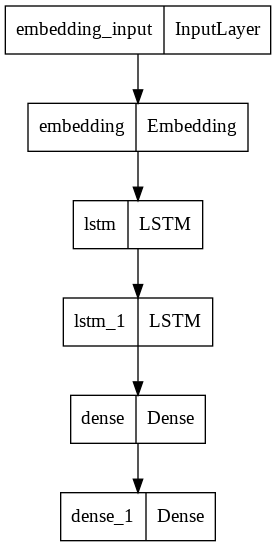

In [11]:
from tensorflow import keras
from keras.utils.vis_utils import plot_model

keras.utils.plot_model(model, to_file='model.png', show_layer_names=True)

In [14]:
# compile network
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model.fit(train_inputs,train_targets,epochs=150, batch_size=64, callbacks=[checkpoint, reduce],verbose=1)
model.save("mymodel.h5")

Epoch 1/150
86/87 [============================>.] - ETA: 0s - loss: 6.1921 - accuracy: 0.1235
Epoch 1: loss improved from 6.26565 to 6.19378, saving model to nextword1.h5
87/87 [==============================] - 5s 18ms/step - loss: 6.1938 - accuracy: 0.1235 - lr: 0.0010
Epoch 2/150
87/87 [==============================] - ETA: 0s - loss: 5.8759 - accuracy: 0.1244
Epoch 2: loss improved from 6.19378 to 5.87591, saving model to nextword1.h5
87/87 [==============================] - 1s 17ms/step - loss: 5.8759 - accuracy: 0.1244 - lr: 0.0010
Epoch 3/150
86/87 [============================>.] - ETA: 0s - loss: 5.6252 - accuracy: 0.1266
Epoch 3: loss improved from 5.87591 to 5.62152, saving model to nextword1.h5
87/87 [==============================] - 1s 17ms/step - loss: 5.6215 - accuracy: 0.1269 - lr: 0.0010
Epoch 4/150
84/87 [===========================>..] - ETA: 0s - loss: 5.3968 - accuracy: 0.1293
Epoch 4: loss improved from 5.62152 to 5.40559, saving model to nextword1.h5
87/87 [==

In [50]:

from keras_preprocessing.sequence import pad_sequences
input_text = input().strip().lower()
encoded_text = tokenizer.texts_to_sequences([input_text])[0]
pad_encoded = pad_sequences([encoded_text], maxlen=seq_len, padding='pre', truncating='pre')
print(encoded_text, pad_encoded)
for i in (model.predict(pad_encoded)[0]).argsort()[-3:][::-1]:
  pred_word = tokenizer.index_word[i]
  print("Next word suggestion:",pred_word)

he found himself 
[13, 725, 37] [[725  37]]
1/1 [==============================] - 0s 17ms/step
Next word suggestion: junk
Next word suggestion: wild
Next word suggestion: accept


### Question 3

Modify your auto-complete so that it never suggests names of people or places.
Include a code snippet and examples in your response.


In [ ]:
from nltk.tag import pos_tag
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
from nltk.chunk import ne_chunk
nltk.download('words')
nltk.download('maxent_ne_chunker')
ne_tree = ne_chunk(pos_tag(word_tokenize(data)))


[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.


In [ ]:
from nltk import Tree
nltk_results = ne_chunk(pos_tag(word_tokenize(data)))
for nltk_result in nltk_results:
    if type(nltk_result) == Tree:
        name = ''
        for nltk_result_leaf in nltk_result.leaves():
            name += nltk_result_leaf[0] + ' '
        print('Type: ', nltk_result.label(), ' Name: ', name)

Type:  PERSON  Name:  Gregor Samsa 
Type:  PERSON  Name:  Samsa 
Type:  PERSON  Name:  Gregor 
Type:  ORGANIZATION  Name:  Hell 
Type:  GPE  Name:  Heaven 
Type:  GPE  Name:  Gregor 
Type:  PERSON  Name:  Gregor 
Type:  PERSON  Name:  Gregor 
Type:  GPE  Name:  Gregor 
Type:  PERSON  Name:  Gregor 
Type:  PERSON  Name:  Gregor 
Type:  GPE  Name:  Gregor 
Type:  GPE  Name:  Gregor 
Type:  GPE  Name:  Gregor 
Type:  GPE  Name:  Gregor 
Type:  GPE  Name:  Gregor 
Type:  PERSON  Name:  Gregor 
Type:  GPE  Name:  Gregor 
Type:  PERSON  Name:  Gregor 
Type:  GPE  Name:  Gregor 
Type:  GPE  Name:  Gregor 
Type:  PERSON  Name:  Gregor 
Type:  PERSON  Name:  Gregor 
Type:  PERSON  Name:  Gregor 
Type:  PERSON  Name:  Gregor 
Type:  GPE  Name:  Gregor 
Type:  GPE  Name:  Gregor 
Type:  PERSON  Name:  Gregor 
Type:  GPE  Name:  Gregor 
Type:  GPE  Name:  Gregor 
Type:  GPE  Name:  Gregor 
Type:  GPE  Name:  Gregor 
Type:  PERSON  Name:  Mr. Samsa 
Type:  GPE  Name:  Gregor 
Type:  PERSON  Name:  

The idea is to to remove the output from the line above from the data, then retrain it with the LSTM model. The suggestion result won't include name and locations. As one can easily spot some mistakes from the result above, one can manually remove them from the data. 